<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install --quiet fastai==2.2.5

# Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
# data = pd.get_dummies(data)

In [5]:
cols = mf.get_col(data)

In [6]:
from fastai.tabular.all import *

In [7]:
categorical_col = data.select_dtypes(include=['object']).columns.tolist()

In [8]:
numerical_col = []
for col in data.columns:
  if col not in categorical_col and col != 'isFraud':
    cont_names.append(col)
# cont_names

Tutorial: https://docs.fast.ai/tutorial.tabular.html

Book: https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [9]:
fasted = TabularPandas(data, procs=[Categorify],
                   cat_names = categorical_col,
                   cont_names = numerical_col,
                   y_names='isFraud')
                  #  splits=splits)

In [10]:
X_train, y_train = fasted.train.xs, fasted.train.ys.values.ravel()
# X_test, y_test = fasted.valid.xs, fasted.valid.ys.values.ravel()

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [11]:
def overSampling(X, y, frac_over=0.1):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
X_train, y_train = overSampling(X_train, y_train)

In [14]:
save_id = False 

if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

load_id = False 
if load_id:
  mf.load_list('train_id',train_id)
  mf.load_list('val_id', val_id)
  mf.load_list('test_id', test_id)

# Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

keras.backend.clear_session()
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary(line_length=88)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

keras.backend.clear_session()

model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.7)) 
# model.add(Dense(1000, activation='relu')) 
# model.add(Dropout(0.7)) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.2)) 
# model.add(Dense(256, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(24, activation='relu')) 
# model.add(Dropout(0.2))
# model.add(Dense(4, activation='relu')) 
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                13504     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,569
Trainable params: 13,569
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=80, 
    batch_size=500, 
    validation_data=(X_val,y_val),
    verbose=1,
    shuffle = True , #class_weight = {0: 1, 1: ratio / 2}
)

Epoch 1/80
753/753 [==============================] - 5s 4ms/step - loss: 0.5140 - accuracy: 0.8906 - val_loss: 0.1520 - val_accuracy: 0.9654
Epoch 2/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2734 - accuracy: 0.9087 - val_loss: 0.1512 - val_accuracy: 0.9654
Epoch 3/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2605 - accuracy: 0.9100 - val_loss: 0.1402 - val_accuracy: 0.9654
Epoch 4/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2597 - accuracy: 0.9090 - val_loss: 0.1437 - val_accuracy: 0.9655
Epoch 5/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2556 - accuracy: 0.9107 - val_loss: 0.1478 - val_accuracy: 0.9658
Epoch 6/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2537 - accuracy: 0.9110 - val_loss: 0.1382 - val_accuracy: 0.9667
Epoch 7/80
753/753 [==============================] - 2s 3ms/step - loss: 0.2509 - accuracy: 0.9121 - val_loss: 0.1383 - val_accuracy: 0.9669
Epoch 

# Performance evaluation

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

3691/3691 [==============================] - 6s 1ms/step - loss: 0.1238 - accuracy: 0.9678

Test Loss:	 0.12375960499048233
Test Accuracy:	 0.9678257703781128


In [19]:
y_pred = model.predict(X_test)

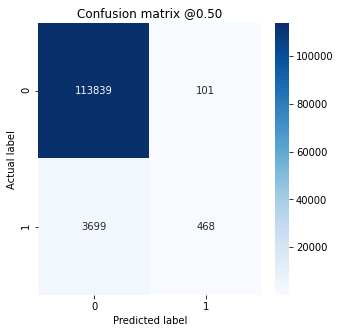

In [20]:
mf.plot_cm(y_test, y_pred, 'Blues')

AUC:  0.8575647860756712


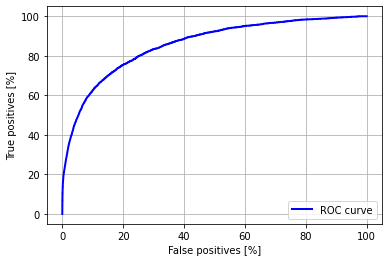

In [21]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.34381838254758135


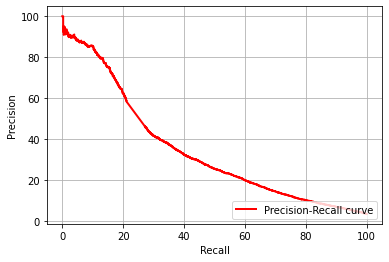

In [22]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')

In [23]:
y_predicted = []
for prob in y_pred:
  if prob >= 0.5:
    y_predicted.append(1)
  else:
    y_predicted.append(0)

In [24]:
from sklearn.metrics import f1_score, recall_score, precision_score
print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))

F1 score:  0.19763513513513511
Recall:  0.11231101511879049
Precision:  0.8224956063268892
